In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils
from utils.callbacks import EvalCallback

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

from finrl.plot import backtest_stats

%load_ext autoreload
%autoreload 2

c:\ProgramData\Anaconda3\envs\rl_study\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\ProgramData\Anaconda3\envs\rl_study\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-ser

In [2]:
env_kwargs = {'stock_dim': 1, 'hmax': 200, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 14, 'action_space': 1, 'tech_indicator_list': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000} 

args = {'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 200, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 10, 'n_repeats_by_trial': 3, 'output_path': 'DDPG_200_TECH', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundamental_indicators': False, 'use_tech_indicators': True, 'indicators': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']}

In [39]:
HYPERPARAMETERS_PATH = '..\TUNING\PETR4\DDPG_200_TECH'

In [40]:
# env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
# args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
# print('ENV KWARGS')
# print(env_kwargs, '\n')
# print('ARGS')
# print(args)

# TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
# os.makedirs(TEST_PATH, exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

ENV KWARGS
{'stock_dim': 1, 'hmax': 200, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 14, 'action_space': 1, 'tech_indicator_list': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000} 

ARGS
{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 200, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 10, 'n_repeats_by_trial': 3, 'output_path': 'DDPG_200_TECH', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundamental_indicators': False, 'use_tech_indicators': True, 'indicators': ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 

In [41]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric          
                                                                mean       std
3     3  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  1.914455  0.594647
7     7  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  1.891699  1.006856
4     4  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  1.433909  0.197793
6     6  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  1.347183  0.000000
8     8  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  1.347183  0.000000

Best Trial: 3 | Mean Metric: 1.9145 +- 0.5946


{'gamma': 0.98,
 'learning_starts': 2000,
 'learning_rate': 0.0004770314404148547,
 'batch_size': 512,
 'buffer_size': 10000}

In [3]:
best_params = {'gamma': 0.98,
 'learning_starts': 2000,
 'learning_rate': 0.0004770314404148547,
 'batch_size': 512,
 'buffer_size': 10000}

In [10]:
# df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))
df = pd.read_pickle(os.path.join('..\TUNING\PETR4\DDPG_200_17_18_FUND_SORTINO', 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, '2021-01-01', '2021-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 1.098681634563044
Eval	 0.2960293754293346
Trade	 0.14384809817977207


USANDO BEST MODEL
TIMESTEPS: 4850


,Model,Buy and Hold
Annual return,0.223556,0.072482
Cumulative returns,0.473307,0.143848
Annual volatility,0.429894,0.580281
Sharpe ratio,0.692472,0.424109
Calmar ratio,0.532403,0.114405
Stability,0.655799,0.398792
Max drawdown,-0.419900,-0.633561
Omega ratio,1.154769,1.089995
Sortino ratio,0.930538,0.567288
Skew,NaN,NaN


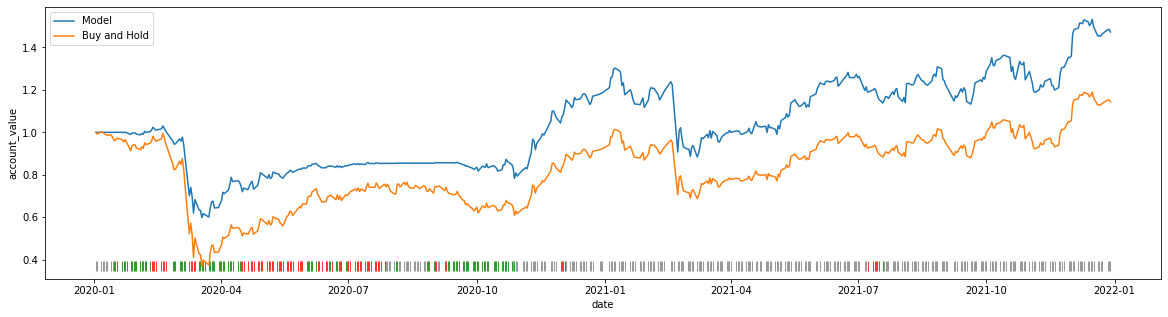

USANDO BEST MODEL
TIMESTEPS: 2910


,Model,Buy and Hold
Annual return,0.069691,0.072482
Cumulative returns,0.138136,0.143848
Annual volatility,0.474357,0.580281
Sharpe ratio,0.391456,0.424109
Calmar ratio,0.113353,0.114405
Stability,0.409278,0.398792
Max drawdown,-0.614811,-0.633561
Omega ratio,1.098513,1.089995
Sortino ratio,0.519082,0.567288
Skew,NaN,NaN


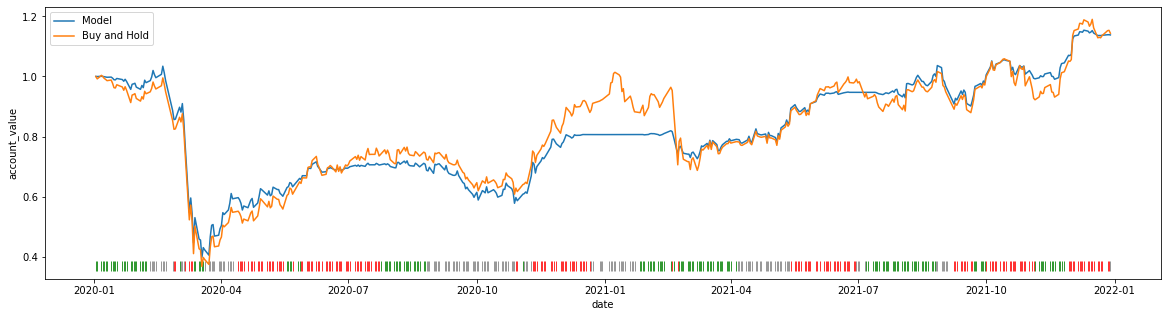

USANDO BEST MODEL
TIMESTEPS: 18430


,Model,Buy and Hold
Annual return,0.115295,0.072482
Cumulative returns,0.233158,0.143848
Annual volatility,0.326363,0.580281
Sharpe ratio,0.502477,0.424109
Calmar ratio,0.254578,0.114405
Stability,0.645876,0.398792
Max drawdown,-0.452888,-0.633561
Omega ratio,1.178893,1.089995
Sortino ratio,0.685542,0.567288
Skew,NaN,NaN


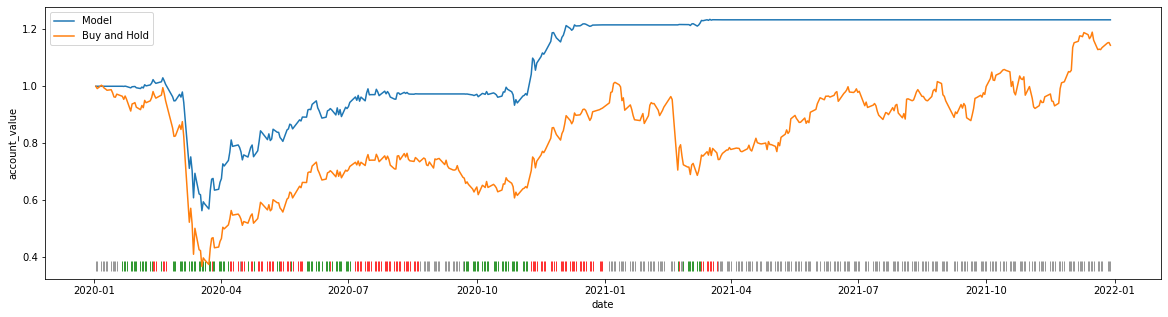

In [43]:
a = 3

MODEL_TYPE = 'best' # *'best' or 'final'

for b in range(0, 10):
    try:
        dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
        dataset['date'] = pd.to_datetime(dataset['date'])

        e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
        env_eval = DummyVecEnv([lambda: e_eval_gym])

        env_statistics_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'env_statistics_{MODEL_TYPE}'
        )

        env_eval = VecNormalize.load(
            env_statistics_path,
            env_eval,
        )
        env_eval.training = False
        env_eval.norm_reward = False

        best_model_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            f'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'model_{MODEL_TYPE}.zip'
        )

        MODEL = model_utils.get_model(args['alg'])
        trained_model = MODEL.load(best_model_path, env_eval)

        print('USANDO BEST MODEL')
        print('TIMESTEPS:', trained_model.num_timesteps)


        account_memory, actions_memory, state_memory = model_utils.predict(
            trained_model, 
            env_eval, 
            True
        )

        account_temp = pd.DataFrame({
            'date': account_memory['date'],
            'account_value': dataset['close']
        })

        display(
            pd.concat([
                backtest_stats(account_value=account_memory),
                backtest_stats(account_value=account_temp)
            ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
        )

        cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
        cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

        actions_plot = np.where(
            actions_memory['actions'] > 0, 
            'green', 
            np.where(actions_memory['actions'] < 0,
                'red',
                'gray'
            )
        ).tolist() + ['gray']

        %matplotlib inline
        plt.figure(figsize=(20,5))
        sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
        sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

        sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
        plt.show()

    except Exception as e:
        break

## Retreino

In [5]:
from utils.file_utils import uniquify

In [11]:
def train_and_return_model(
    train_set,
    trade_set,
    env_kwargs,
    algorithm,
    train_episodes,
    model_params,
    best_model_path,
    return_best_model=False
):

    best_model_path = uniquify(best_model_path)

    os.makedirs(best_model_path, exist_ok=True)
    
    train_set = train_set.copy()

    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    env_train = DummyVecEnv([lambda: e_train_gym])
    env_train = VecMonitor(
        env_train, 
        best_model_path
    )

    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=model_params['gamma']
    )
    MODEL = model_utils.get_model(algorithm)
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **model_params,
        verbose=False,
        seed=None,
        tensorboard_log=os.path.join(best_model_path)
    )

    eval_callback = EvalCallback(
        env_train, 
        n_eval_episodes=1,
        eval_freq=int(train_set.shape[0]),
        best_model_save_path=os.path.join(best_model_path),
        verbose=False
    )
    trained_model = model.learn(
        tb_log_name='retreino',
        log_interval=1,
        total_timesteps=train_set.shape[0] * train_episodes,
        callback=[eval_callback],
        reset_num_timesteps=True
    )

    if not return_best_model:
        return trained_model
    else:
        e_trade_gym = StockTradingEnv(df=trade_set, **env_kwargs)
        env_trade = DummyVecEnv([lambda: e_trade_gym])
        env_trade = VecNormalize.load(
            os.path.join(best_model_path, 'env_statistics_best'), env_trade
        )
        env_trade.training = False
        env_trade.norm_reward = False

        MODEL = model_utils.get_model(args['alg'])
        best_model = MODEL.load(
            os.path.join(best_model_path, 'model_best.zip'), env_trade
        )
        return best_model

In [15]:
def predict_and_evaluate(model, trade_set, save_path=None):
    print('MODEL TIMESTEPS:', model.num_timesteps)

    account_memory, actions_memory, state_memory = model_utils.predict(
        model, model.env, True
    )

    account_temp = pd.DataFrame({
        'date': account_memory['date'],
        'account_value': trade_set['close']
    })

    display(
        pd.concat([
            backtest_stats(account_value=account_memory),
            backtest_stats(account_value=account_temp)
        ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
    )

    cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
    cum_return_beh = (trade_set['close'].pct_change(1)+1).cumprod().fillna(1)

    actions_plot = np.where(
        actions_memory['actions'] > 0, 
        'green', 
        np.where(
            actions_memory['actions'] < 0,
            'red',
            'gray'
        )
    ).tolist() + ['gray']

    %matplotlib inline
    plt.figure(figsize=(20,5))
    sns.lineplot(x=trade_set['date'], y=cum_return_model, label='Model')
    sns.lineplot(x=trade_set['date'], y=cum_return_beh, label='Buy and Hold')

    sns.scatterplot(x=trade_set['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
    
    if save_path is not None:
        plt.save(os.path.join(save_path, 'returns.png'))
    plt.show()

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,-0.059130,0.072482
Cumulative returns,-0.110472,0.143848
Annual volatility,0.544211,0.580281
Sharpe ratio,0.174181,0.424109
Calmar ratio,-0.093827,0.114405
Stability,0.039347,0.398792
Max drawdown,-0.630209,-0.633561
Omega ratio,1.042348,1.089995
Sortino ratio,0.227661,0.567288
Skew,NaN,NaN


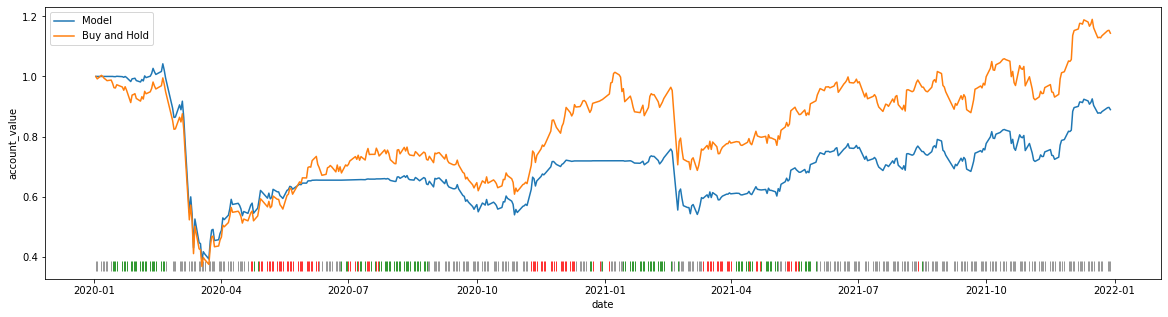

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.073808,0.072482
Cumulative returns,0.146566,0.143848
Annual volatility,0.391954,0.580281
Sharpe ratio,0.383400,0.424109
Calmar ratio,0.142568,0.114405
Stability,0.510377,0.398792
Max drawdown,-0.517708,-0.633561
Omega ratio,1.096849,1.089995
Sortino ratio,0.520219,0.567288
Skew,NaN,NaN


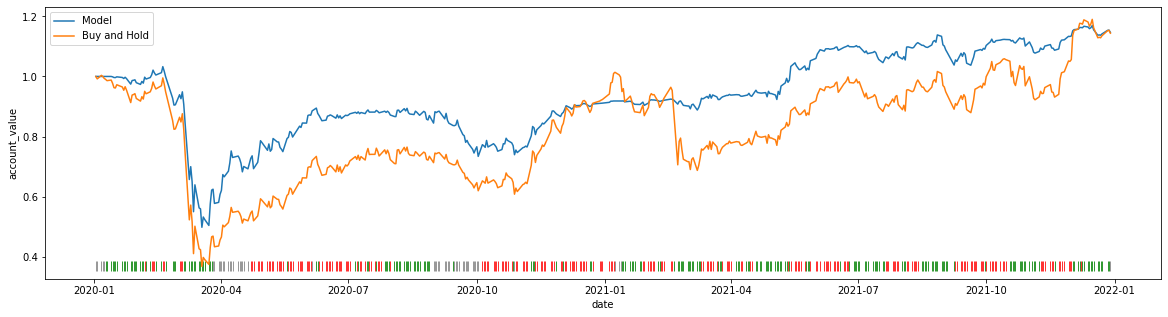

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.277598,0.072482
Cumulative returns,0.600828,0.143848
Annual volatility,0.384196,0.580281
Sharpe ratio,0.833766,0.424109
Calmar ratio,0.590939,0.114405
Stability,0.770824,0.398792
Max drawdown,-0.469758,-0.633561
Omega ratio,1.206179,1.089995
Sortino ratio,1.193990,0.567288
Skew,NaN,NaN


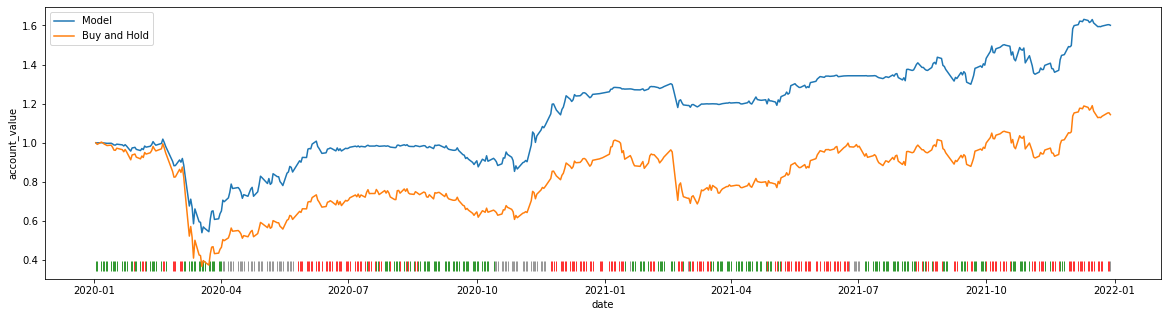

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,-0.030542,0.072482
Cumulative returns,-0.057836,0.143848
Annual volatility,0.523828,0.580281
Sharpe ratio,0.215239,0.424109
Calmar ratio,-0.048601,0.114405
Stability,0.106157,0.398792
Max drawdown,-0.628431,-0.633561
Omega ratio,1.050797,1.089995
Sortino ratio,0.283795,0.567288
Skew,NaN,NaN


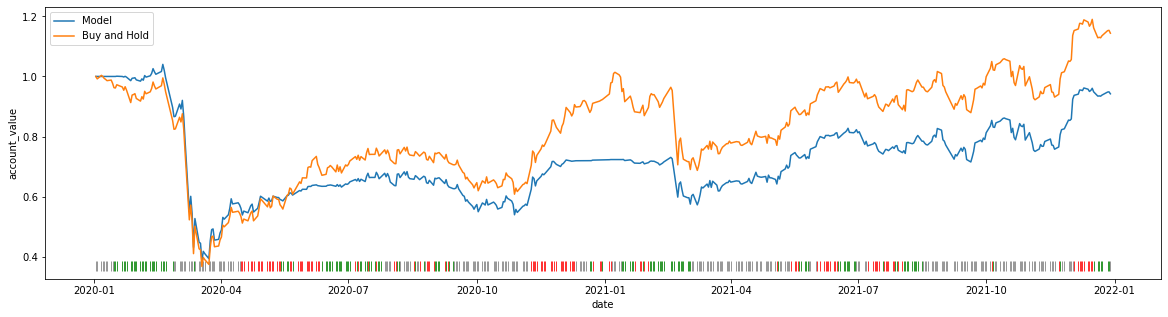

MODEL TIMESTEPS: 5089


,Model,Buy and Hold
Annual return,0.311571,0.072482
Cumulative returns,0.683585,0.143848
Annual volatility,0.461183,0.580281
Sharpe ratio,0.825207,0.424109
Calmar ratio,0.728114,0.114405
Stability,0.724357,0.398792
Max drawdown,-0.427915,-0.633561
Omega ratio,1.173598,1.089995
Sortino ratio,1.151710,0.567288
Skew,NaN,NaN


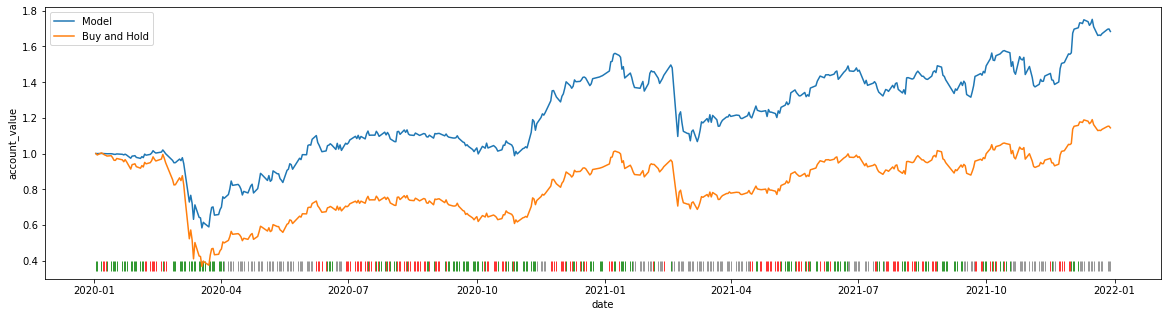

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.424736,0.072482
Cumulative returns,0.973639,0.143848
Annual volatility,0.248039,0.580281
Sharpe ratio,1.553364,0.424109
Calmar ratio,2.073385,0.114405
Stability,0.883382,0.398792
Max drawdown,-0.204852,-0.633561
Omega ratio,1.394973,1.089995
Sortino ratio,2.713459,0.567288
Skew,NaN,NaN


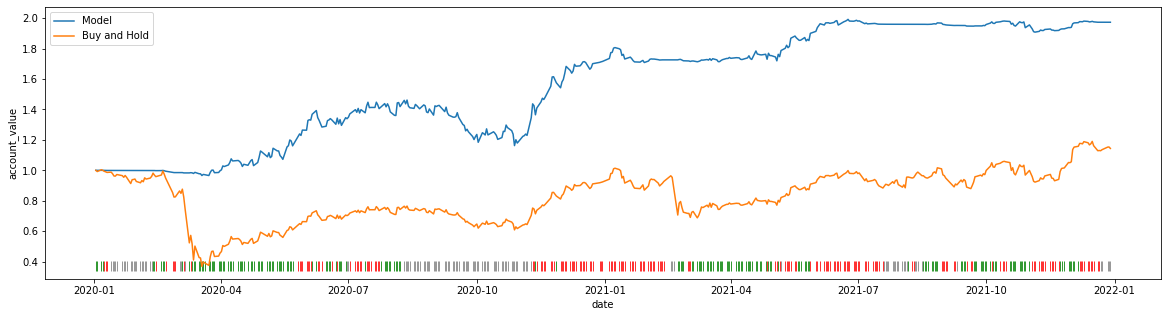

MODEL TIMESTEPS: 4362


,Model,Buy and Hold
Annual return,0.165149,0.072482
Cumulative returns,0.341204,0.143848
Annual volatility,0.286489,0.580281
Sharpe ratio,0.679786,0.424109
Calmar ratio,0.514408,0.114405
Stability,0.571089,0.398792
Max drawdown,-0.321047,-0.633561
Omega ratio,1.145796,1.089995
Sortino ratio,0.959143,0.567288
Skew,NaN,NaN


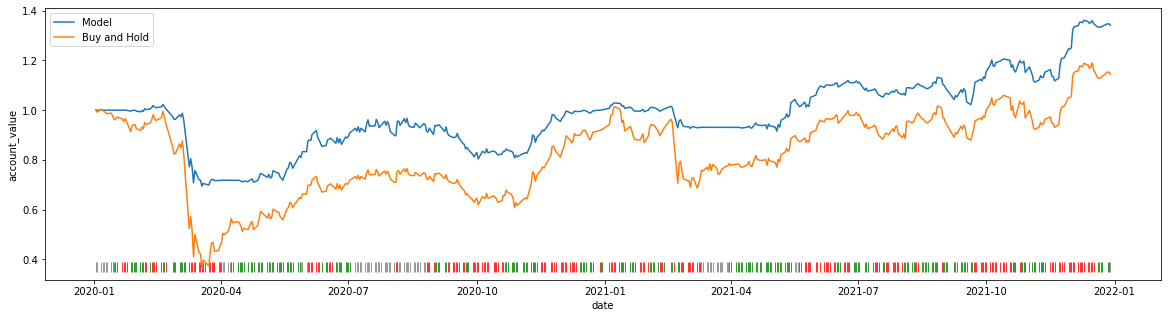

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.360866,0.072482
Cumulative returns,0.807218,0.143848
Annual volatility,0.280695,0.580281
Sharpe ratio,1.239727,0.424109
Calmar ratio,1.612096,0.114405
Stability,0.886700,0.398792
Max drawdown,-0.223849,-0.633561
Omega ratio,1.323146,1.089995
Sortino ratio,2.015686,0.567288
Skew,NaN,NaN


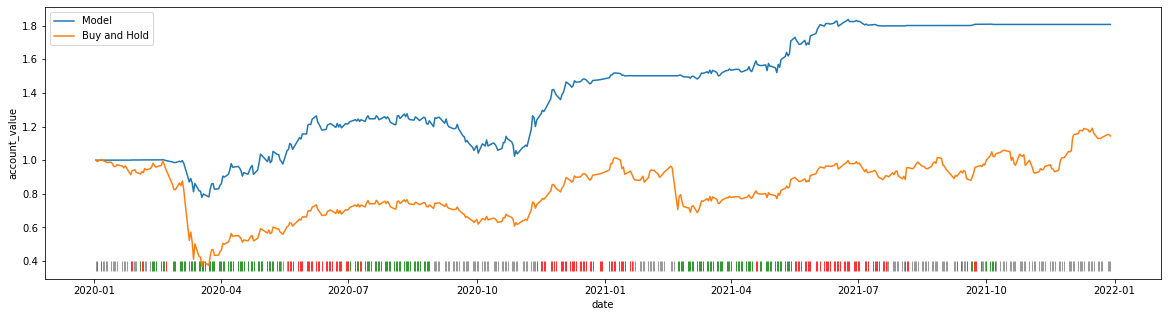

MODEL TIMESTEPS: 2908


,Model,Buy and Hold
Annual return,0.093899,0.072482
Cumulative returns,0.188121,0.143848
Annual volatility,0.578910,0.580281
Sharpe ratio,0.457984,0.424109
Calmar ratio,0.148948,0.114405
Stability,0.407383,0.398792
Max drawdown,-0.630411,-0.633561
Omega ratio,1.098370,1.089995
Sortino ratio,0.612843,0.567288
Skew,NaN,NaN


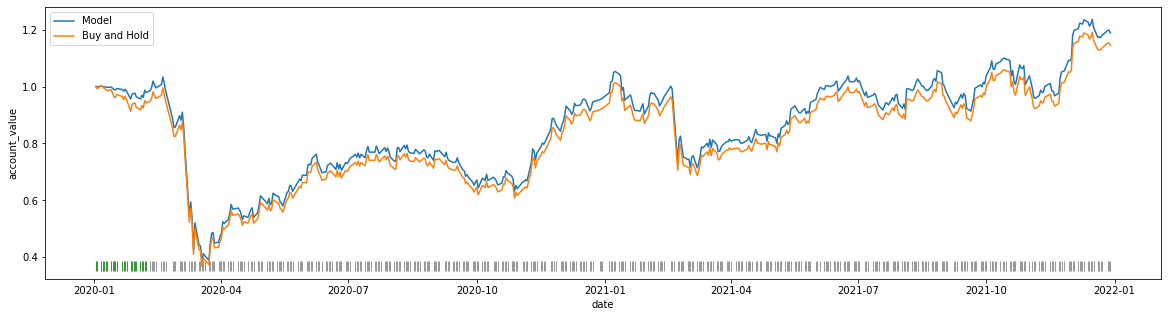

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.065853,0.072482
Cumulative returns,0.130306,0.143848
Annual volatility,0.504223,0.580281
Sharpe ratio,0.391116,0.424109
Calmar ratio,0.104468,0.114405
Stability,0.349403,0.398792
Max drawdown,-0.630359,-0.633561
Omega ratio,1.100090,1.089995
Sortino ratio,0.523262,0.567288
Skew,NaN,NaN


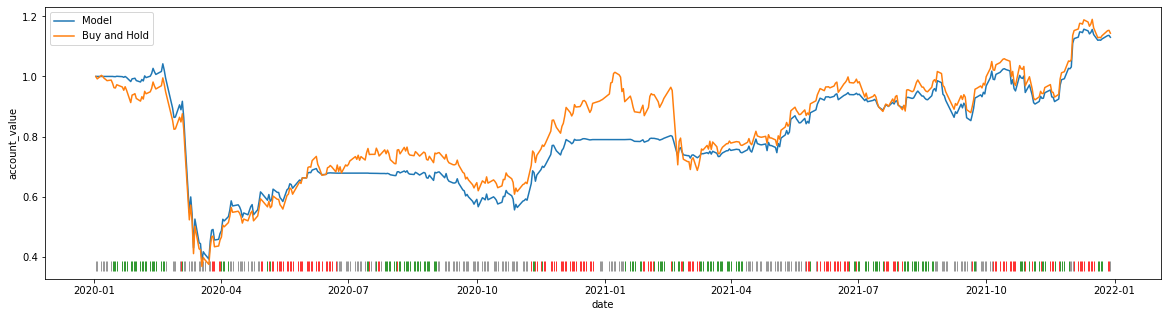

In [17]:
for i in range(10):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=10,
        model_params=best_params,
        return_best_model=True,
        best_model_path=os.path.join(
            '..',
            'retrain_and_evaluation',
            'DDPG_200_TECH',
            f'retrain_folder_{i}'
        )
    )

    predict_and_evaluate(model, trade_set)



MODEL TIMESTEPS: 71246


,Model,Buy and Hold
Annual return,0.313790,0.072482
Cumulative returns,0.689059,0.143848
Annual volatility,0.277391,0.580281
Sharpe ratio,1.123492,0.424109
Calmar ratio,1.559916,0.114405
Stability,0.832798,0.398792
Max drawdown,-0.201158,-0.633561
Omega ratio,1.264122,1.089995
Sortino ratio,1.851442,0.567288
Skew,NaN,NaN


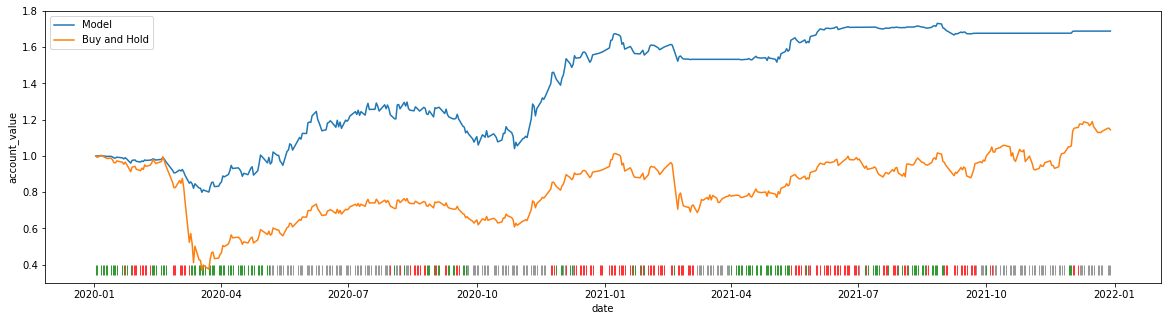

MODEL TIMESTEPS: 56706


,Model,Buy and Hold
Annual return,0.284151,0.072482
Cumulative returns,0.616634,0.143848
Annual volatility,0.252970,0.580281
Sharpe ratio,1.117179,0.424109
Calmar ratio,1.513992,0.114405
Stability,0.854310,0.398792
Max drawdown,-0.187683,-0.633561
Omega ratio,1.272601,1.089995
Sortino ratio,1.727178,0.567288
Skew,NaN,NaN


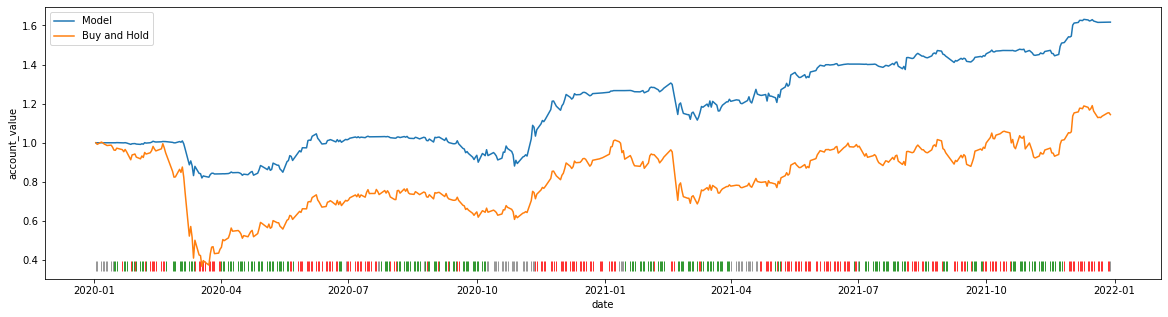

KeyboardInterrupt: 

In [18]:
for i in range(10):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=100,
        model_params=best_params,
        return_best_model=True,
        best_model_path=os.path.join(
            '..',
            'retrain_and_evaluation',
            'DDPG_200_TECH',
            f'retrain_folder_{i}'
        )
    )

    predict_and_evaluate(model, trade_set)

In [25]:
e_train_gym = StockTradingEnv(
    df=train_set, 
    **env_kwargs
)
env_train = DummyVecEnv([lambda: e_train_gym])
env_train = VecMonitor(
    env_train, 
    os.path.join('.')
)

env_train = VecNormalize(
    env_train, 
    training=True,
    norm_obs=True, 
    norm_reward=True,
    gamma=best_params['gamma']
)
MODEL = model_utils.get_model(args['alg'])
model = MODEL(
    policy='MlpPolicy', 
    env=env_train,
    **best_params,
    verbose=True,
    seed=None,
    tensorboard_log=os.path.join('.')
)

eval_callback = EvalCallback(
    env_train, 
    n_eval_episodes=1,
    eval_freq=int(train_set.shape[0]/len(args['tickers'])),
    best_model_save_path=os.path.join('.'),
    verbose=False
)
trained_model = model.learn(
    tb_log_name='retreino',
    log_interval=1,
    total_timesteps=train_set.shape[0] * 10,
    callback=[eval_callback],
    reset_num_timesteps=True
)

Using cuda device
Logging to .\retreino_8
---------------------------------
| eval/              |          |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 727      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 727       |
|    ep_rew_mean     | 6922.8413 |
| time/              |           |
|    episodes        | 1         |
|    fps             | 208       |
|    time_elapsed    | 3         |
|    total_timesteps | 727       |
----------------------------------
---------------------------------
| eval/              |          |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 1454     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 727      |
|    ep_rew_mean     | 5334.251 |
| time/              |          |
|    episodes        | 2      

USANDO BEST MODEL
TIMESTEPS: 36350


,Model,Buy and Hold
Annual return,-0.010201,0.072482
Cumulative returns,-0.019501,0.143848
Annual volatility,0.485199,0.580281
Sharpe ratio,0.234383,0.424109
Calmar ratio,-0.016325,0.114405
Stability,0.148011,0.398792
Max drawdown,-0.624911,-0.633561
Omega ratio,1.067882,1.089995
Sortino ratio,0.307731,0.567288
Skew,NaN,NaN


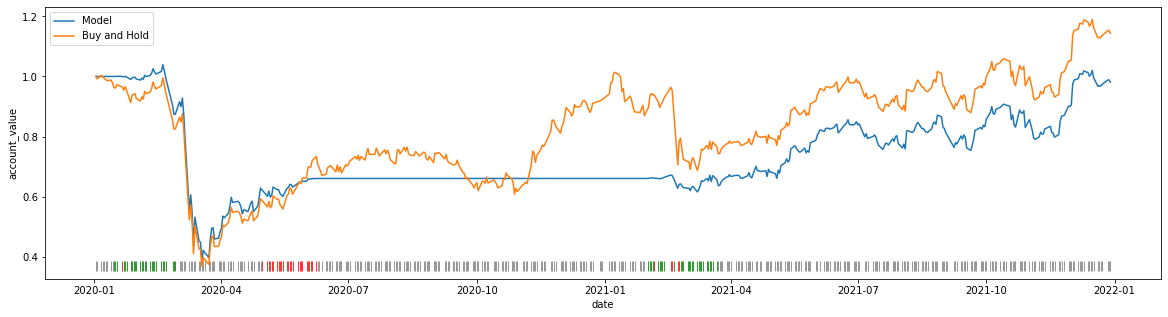

In [26]:
dataset = trade_set.copy()

e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecNormalize.load(os.path.join('.', 'env_statistics_best'), env_eval)

env_eval.training = False
env_eval.norm_reward = False

MODEL = model_utils.get_model(args['alg'])
best_model = MODEL.load(os.path.join('.', 'model_best.zip'), env_eval)

print('USANDO BEST MODEL')
print('MODEL TIMESTEPS:', best_model.num_timesteps)

account_memory, actions_memory, state_memory = model_utils.predict(
    best_model, 
    env_eval, 
    True
)

account_temp = pd.DataFrame({
    'date': account_memory['date'],
    'account_value': dataset['close']
})

display(
    pd.concat([
        backtest_stats(account_value=account_memory),
        backtest_stats(account_value=account_temp)
    ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(
        actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

%matplotlib inline
plt.figure(figsize=(20,5))
sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
plt.show()
